In [1]:
#Import libraries
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math

In [2]:
#Read image

input_image = cv2.imread('lenna.png')
input_image = cv2.cvtColor(src=input_image, code=cv2.COLOR_BGR2GRAY)

In [3]:
def displayImage(image):
  
  plt.subplot(1,4,1)

  # Display the image in grayscale with the minimum value mapped to 0 and the maximum value mapped to 255
  
  plt.imshow(image,'gray',vmin=0,vmax=255)

  # Get the current figure object and set its size to 20 inches by 20 inches
  fig = plt.gcf()
  fig.set_size_inches(20, 20)

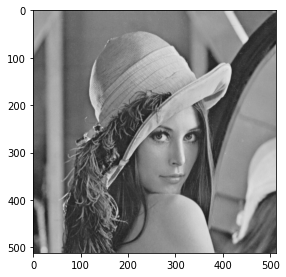

In [4]:
displayImage(input_image)

In [5]:
def convolve2d(image, kernel):

  # Flip the kernel both horizontally and vertically

  kernel = np.flipud(np.fliplr(kernel))

  # Determine the size of the kernel and setting stride

  k_sizeX, k_sizeY = kernel.shape

  stride = 1

  pad_x = k_sizeX//2
  pad_y = k_sizeY//2

  # Pad the input image with zeros to ensure that convolution can be performed across the edges of the image

  image = np.pad(image, ((pad_y, pad_y),(pad_x, pad_x)))

  im_sizeX, im_sizeY = image.shape

  # Create an output array of zeros with the same dimensions as the padded image

  output = np.zeros((im_sizeX,im_sizeY))
    
  # If the bottom of the kernel extends past the bottom of the image, break the loop

  for y in range(0, im_sizeY, stride):
    if y > im_sizeY-k_sizeY:
      break

  # If the right side of the kernel extends past the right side of the image, break the loop

    for x in range(0,im_sizeX, stride):
      if x > im_sizeX-k_sizeX:
        break
    
      # Compute the output value for this position in the output array by multiplying the kernel with the corresponding region of the input image and summing the products

      output[int(np.floor((2*x+k_sizeX)/2*stride)),int(np.floor((2*y+k_sizeY)/2*stride))] = (kernel * image[x:x+k_sizeX, y:y+k_sizeY]).sum()
  
  # Crop the output array to remove the padding and scale output values between 0 and 255
  
  output = output[pad_x:(im_sizeX-pad_x)//stride, pad_y:(im_sizeY-pad_y)//stride]
  
  return output

In [6]:
def normalize(image):

  # Divide each pixel value in the image by the maximum pixel value in the image and then multiply by 255
  # This will normalize the pixel values between 0 and 1, and then rescale them to between 0 and 255
  # The result is a normalized image with pixel values ranging between 0 and 255

  return (image/np.max(image))*255

In [7]:
def gaussianBlur(input_image):

  # Define a 5x5 Gaussian kernel named 'G' with the specified weights
  
  G = (1/273) * np.array([[1,4,7,4,1],
                        [4,16,26,16,4],
                        [7,26,41,26,7],
                        [4,16,26,16,4],
                        [1,4,7,4,1]])
  
  return normalize(convolve2d(input_image, G))

In [8]:
def sobelOperator(input_image):

  # Define 3x3 Sobel filters for x- and y-directions named 'Sx' and 'Sy', respectively

  Sx = np.array([[-1, 0, 1],
                [ -2, 0, 2],
                [-1, 0, 1]])
  Sy = np.array([[-1, -2, -1],
                [0, 0, 0],
                [1, 2, 1]])
  
  # Convolve the input image with the Sobel filters using the 'convolve2d' function
  # The resulting images are the x- and y-gradients of the input image
  # The 'normalize' function is then called to normalize the pixel values between 0 and 255

  Gx = normalize(convolve2d(input_image, Sx))
  Gy = normalize(convolve2d(input_image, Sy))

  # Compute the gradient magnitude of the input image using the x- and y-gradients

  G = normalize(np.sqrt(Gx*Gx + Gy*Gy))

  # Compute the gradient direction of the input image using the x- and y-gradients
  # The 'np.degrees' function converts the result from radians to degrees

  gradient_direction = np.degrees(np.arctan2(Gy,Gx))

  return G, gradient_direction

In [9]:
def return_direction(angle):

  if (angle >= -22.5 and angle <= 22.5) or (angle <= -157.5 and angle >= 157.5):
    return 0

  elif (angle >= 22.5 and angle <= 67.5) or (angle <= -112.5 and angle >= -157.5):
    return 1

  elif (angle >= 67.5 and angle <= 112.5) or (angle <= -67.5 and angle >= -112.5):
    return 2

  elif (angle >= 112.2 and angle <= 157.5) or (angle <= -22.5 and angle >= -67.5):
    return 3

In [10]:
def nonMaxSuppression(G, gradient_direction):

  # Loop through each pixel in the G matrix

  for i in range(len(G)):
    for j in range(len(G[0])):

      # Determine the sector based on the gradient direction of the pixel

      sector = return_direction(gradient_direction[i][j])

      # Check the appropriate neighboring pixels based on the sector and set the current pixel to 0 if its magnitude is smaller
      
      if (sector == 0):
        if (j > 0 and j < len(G[0])-1):
          if G[i][j] < G[i][j-1] or G[i][j] < G[i][j+1]:
            G[i][j] = 0
      
      elif (sector == 1):
        if (j > 0 and j < len(G[0])-1 and i > 0 and  i < len(G)-1):
          if G[i][j] < G[i-1][j+1] or G[i][j] < G[i+1][j-1]:
            G[i][j] = 0

      elif (sector == 2):
        if (i > 0 and i < len(G)-1):
          if G[i][j] < G[i-1][j] or G[i][j] < G[i+1][j]:
            G[i][j] = 0
      
      else:
        if (j > 0 and j < len(G[0])-1 and i > 0 and  i < len(G)-1):
          if G[i][j] < G[i-1][j-1] or G[i][j] < G[i+1][j+1]:
            G[i][j] = 0
  
  return G

In [11]:
gradients, gradient_direction = sobelOperator(gaussianBlur(input_image))
suppressed_image = nonMaxSuppression(gradients, gradient_direction)

In [12]:
def applyThresholding(image, threshold):

  # Initialize edge count variable

  edge_count = 0

  # Loop through image pixels

  for i in range(len(image)):
    for j in range(len(image[0])):

      # Apply thresholding

      if (image[i][j] <= threshold):
        image[i][j] = 0

      else:
        image[i][j] = 255
        edge_count +=1

  # Print edge count

  print("The edge count is : ", edge_count)

  # Return thresholded image
  
  return image

In [13]:
def pThresholding(image, percentile):

  # Create an empty list to store all non-zero pixel values in the image

  pixel_array = []

  # Iterate over every pixel in the image

  for i in range(len(image)):
    for j in range(len(image[0])):
      
      # If the pixel value is greater than 0, add it to the list

      if (image[i][j] > 0):
        pixel_array.append(image[i][j])

  # Sort the list of pixel values in ascending order

  pixel_array.sort()

  # Calculate the index of the threshold value in the sorted list using the given percentile

  threshold_index = int(percentile * len(pixel_array) - 1)
  threshold = pixel_array[threshold_index]

  # Print the threshold value

  print("The threshold value is : ", threshold)

  # Apply thresholding to the image using the threshold value
  
  return applyThresholding(image, threshold)

In [14]:
final_image = pThresholding(suppressed_image, 0.90)

The threshold value is :  39.18246647018566
The edge count is :  8056


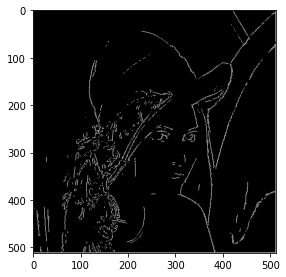

In [15]:
displayImage(final_image)